In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.feature_selection import IntrinsicFeatureSelection as ifs
from src import plotting

# Supervised, intrinsic feature selection

In [2]:
proc = GatherFeatureDatasets(is_p=False)

## Load the data

In [3]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
train = pd.read_csv(f'{data_dir}/s.train.csv')
test = pd.read_csv(f'{data_dir}/s.test.csv')

In [4]:
proc.compute_feature_matrix

<function src.processing.SFeatures.compute_feature_matrix(df, freq_max=18, scaler=True, source_dist_type='dist', linear_model=True, w_r=0.5)>

## Process the features for each station

In [5]:
station_feature_dict, station_meta_dict, feature_names = proc.process_all_stations_datasets(train, 
                                                                  test, 
                                                                  scaler=True,
                                                                  linear_model=True,
                                                                  source_dist_type='all')

YHB
X shape: (942, 47), y shape: (942,)
X shape: (227, 47), y shape: (227,)
YHL
X shape: (468, 47), y shape: (468,)
X shape: (114, 47), y shape: (114,)
YMR
X shape: (1293, 47), y shape: (1293,)
X shape: (303, 47), y shape: (303,)
YHH
X shape: (883, 47), y shape: (883,)
X shape: (214, 47), y shape: (214,)
B207
X shape: (314, 47), y shape: (314,)
X shape: (81, 47), y shape: (81,)
FLWY
X shape: (310, 47), y shape: (310,)
X shape: (78, 47), y shape: (78,)
YPP
X shape: (157, 47), y shape: (157,)
X shape: (44, 47), y shape: (44,)
YNR
X shape: (1784, 47), y shape: (1784,)
X shape: (454, 47), y shape: (454,)
YUF
X shape: (725, 47), y shape: (725,)
X shape: (190, 47), y shape: (190,)
YML
X shape: (421, 47), y shape: (421,)
X shape: (107, 47), y shape: (107,)
YFT
X shape: (741, 47), y shape: (741,)
X shape: (188, 47), y shape: (188,)
LKWY
X shape: (203, 47), y shape: (203,)
X shape: (53, 47), y shape: (53,)
YTP
X shape: (382, 47), y shape: (382,)
X shape: (93, 47), y shape: (93,)
B206
X shape: (

In [6]:
print(feature_names)

['amp_ratio_1' 'amp_ratio_2' 'amp_ratio_3' 'amp_ratio_4' 'amp_ratio_5'
 'amp_ratio_6' 'amp_ratio_7' 'amp_ratio_8' 'amp_ratio_9' 'amp_ratio_10'
 'amp_ratio_11' 'amp_ratio_12' 'amp_ratio_13' 'amp_ratio_14'
 'amp_ratio_15' 'amp_ratio_16' 'amp_ratio_17' 'amp_ratio_18' 'amp_1'
 'amp_2' 'amp_3' 'amp_4' 'amp_5' 'amp_6' 'amp_7' 'amp_8' 'amp_9' 'amp_10'
 'amp_11' 'amp_12' 'amp_13' 'amp_14' 'amp_15' 'amp_16' 'amp_17' 'amp_18'
 'signal_dominant_frequency' 'signal_dominant_amplitude'
 'noise_max_amplitude' 'signal_max_amplitude' 'signal_variance'
 'noise_variance' 'source_depth_km' 'source_latitude' 'source_longitude'
 'source_receiver_distance_logkm' 'source_receiver_back_azimuth_sine']


In [7]:
alt_names = proc.get_feature_plot_names()
print(np.array(alt_names))

['ratio 1' 'ratio 2' 'ratio 3' 'ratio 4' 'ratio 5' 'ratio 6' 'ratio 7'
 'ratio 8' 'ratio 9' 'ratio 10' 'ratio 11' 'ratio 12' 'ratio 13'
 'ratio 14' 'ratio 15' 'ratio 16' 'ratio 17' 'ratio 18' 'amp. 1' 'amp. 2'
 'amp. 3' 'amp. 4' 'amp. 5' 'amp. 6' 'amp. 7' 'amp. 8' 'amp. 9' 'amp. 10'
 'amp. 11' 'amp. 12' 'amp. 13' 'amp. 14' 'amp. 15' 'amp. 16' 'amp. 17'
 'amp. 18' 'sig. dom. freq.' 'sig. dom. amp.' 'noise max. amp.'
 'sig. max. amp.' 'sig. var.' 'noise var.' 'depth' 'lat.' 'long.'
 'distance' 'back az.']


# Process all the features together

In [8]:
X_train, y_train, scaler, _ = proc.get_X_y(train, 
                                            scaler=True,
                                            source_dist_type='all')

X shape: (10518, 47), y shape: (10518,)


# Do a quick check that the new def for computing features in SFeatures matches the old method since this is the first time I've used the new one and I didn't write unit tests yet 

In [9]:
def test_feature_values():
        # Computes the feature matrix from a dataframe
        def compute_feature_matrix(df, scaler = True):
                # Loosely speaking empirical magnitudes look like:
                # M = log10(A) + Q(Delta) 
                # where A is the amplitude and Q a distance dependent correction term.
                # Additionally, the difference between log10 and log amounts to a scalar
                # that a machine can learn.
                # Basically, I'm interested in features that:
                #   (1) Measure size in, potentially, different amplitudes.
                # different `passbands' deviates from the noise, 
                n_rows = len(df)
                n_columns = 33
                X = np.zeros([n_rows, n_columns])
                # Get a proxy on size
                w1 = 0.5
                w2 = 1 - w1
                # These are effectively amplitude ratios.  Note,
                # log(a/b) = log(a) - log(b)
                X[:,0]  = w1*(np.log(df['radial_avg_signal_1.00']) - np.log(df['radial_avg_noise_1.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_1.00']) - np.log(df['transverse_avg_noise_1.00']))
                X[:,1]  = w1*(np.log(df['radial_avg_signal_2.00']) - np.log(df['radial_avg_noise_2.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_2.00']) - np.log(df['transverse_avg_noise_2.00']))
                X[:,2]  = w1*(np.log(df['radial_avg_signal_3.00']) - np.log(df['radial_avg_noise_3.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_3.00']) - np.log(df['transverse_avg_noise_3.00']))
                X[:,3]  = w1*(np.log(df['radial_avg_signal_4.00']) - np.log(df['radial_avg_noise_4.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_4.00']) - np.log(df['transverse_avg_noise_4.00']))
                X[:,4]  = w1*(np.log(df['radial_avg_signal_5.00']) - np.log(df['radial_avg_noise_5.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_5.00']) - np.log(df['transverse_avg_noise_5.00']))
                X[:,5]  = w1*(np.log(df['radial_avg_signal_6.00']) - np.log(df['radial_avg_noise_6.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_6.00']) - np.log(df['transverse_avg_noise_6.00']))
                X[:,6]  = w1*(np.log(df['radial_avg_signal_7.00']) - np.log(df['radial_avg_noise_7.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_7.00']) - np.log(df['transverse_avg_noise_7.00']))
                X[:,7]  = w1*(np.log(df['radial_avg_signal_8.00']) - np.log(df['radial_avg_noise_8.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_8.00']) - np.log(df['transverse_avg_noise_8.00']))
                X[:,8]  = w1*(np.log(df['radial_avg_signal_9.00']) - np.log(df['radial_avg_noise_9.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_9.00']) - np.log(df['transverse_avg_noise_9.00']))
                X[:,9]  = w1*(np.log(df['radial_avg_signal_10.00']) - np.log(df['radial_avg_noise_10.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_10.00']) - np.log(df['transverse_avg_noise_10.00']))
                X[:,10]  = w1*(np.log(df['radial_avg_signal_11.00']) - np.log(df['radial_avg_noise_11.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_11.00']) - np.log(df['transverse_avg_noise_11.00']))
                X[:,11]  = w1*(np.log(df['radial_avg_signal_12.00']) - np.log(df['radial_avg_noise_12.00'])) \
                        + w2*(np.log(df['transverse_avg_signal_12.00']) - np.log(df['transverse_avg_noise_12.00']))
                
                # Look at amplitudes
                X[:,12] = w1*np.log(df['radial_avg_signal_1.00']) + w2*np.log(df['transverse_avg_signal_1.00']) 
                X[:,13] = w1*np.log(df['radial_avg_signal_2.00']) + w2*np.log(df['transverse_avg_signal_2.00']) 
                X[:,14] = w1*np.log(df['radial_avg_signal_3.00']) + w2*np.log(df['transverse_avg_signal_3.00']) 
                X[:,15] = w1*np.log(df['radial_avg_signal_4.00']) + w2*np.log(df['transverse_avg_signal_4.00']) 
                X[:,16] = w1*np.log(df['radial_avg_signal_5.00']) + w2*np.log(df['transverse_avg_signal_5.00']) 
                X[:,17] = w1*np.log(df['radial_avg_signal_6.00']) + w2*np.log(df['transverse_avg_signal_6.00']) 
                X[:,18] = w1*np.log(df['radial_avg_signal_7.00']) + w2*np.log(df['transverse_avg_signal_7.00']) 
                X[:,19] = w1*np.log(df['radial_avg_signal_8.00']) + w2*np.log(df['transverse_avg_signal_8.00']) 
                X[:,20] = w1*np.log(df['radial_avg_signal_9.00']) + w2*np.log(df['transverse_avg_signal_9.00']) 
                X[:,21] = w1*np.log(df['radial_avg_signal_10.00']) + w2*np.log(df['transverse_avg_signal_10.00']) 
                X[:,22] = w1*np.log(df['radial_avg_signal_11.00']) + w2*np.log(df['transverse_avg_signal_11.00'])
                X[:,23] = w1*np.log(df['radial_avg_signal_12.00']) + w2*np.log(df['transverse_avg_signal_12.00']) 

                
                # Frequency and max amplitude
                X[:,24] = w1*np.log(df['radial_signal_dominant_frequency']) \
                        + w2*np.log(df['transverse_signal_dominant_frequency'])
                X[:,25] = w1*np.log(df['radial_signal_dominant_amplitude']) \
                        + w2*np.log(df['transverse_signal_dominant_amplitude'])
                # Time-based featuers: Look at max amplitudes of noise/signal
                X[:,26] = w1*(np.log(df['radial_noise_maximum_value'] - df['radial_noise_minimum_value'])) \
                        + w2*(np.log(df['transverse_noise_maximum_value'] - df['transverse_noise_minimum_value']))
                X[:,27] = w1*(np.log(df['radial_signal_maximum_value'] - df['radial_signal_minimum_value'])) \
                        + w2*(np.log(df['transverse_signal_maximum_value'] - df['transverse_signal_minimum_value']))
                X[:,28] = w1*np.log(df['radial_signal_variance']) + w2*np.log(df['transverse_signal_variance'])
                X[:,29] = w1*np.log(df['radial_noise_variance']) + w2*np.log(df['transverse_noise_variance'])
                # Source/recv distance (take log to flatten this)
                X[:,30] = df['source_depth_km']
                X[:,31] = np.log(df['source_receiver_distance_km'])
                # Caution - not a great features for linear methods b/c 359 and 361 are similar
                #X[:, 32] = np.sin(df['source_receiver_back_azimuth']*np.pi/180)
                X[:,32] = df['source_receiver_back_azimuth']

                # Standardize features
                if (scaler):
                        scaler = StandardScaler()
                        scaler = scaler.fit(X)
                        X = scaler.transform(X)
                        return X, scaler
                
                return X

        ynr_feat_dict, ynr_meta_dict, ynr_fnames = proc.process_station_datasets('YNR',
                                                                                train,
                                                                                test,
                                                                                freq_max=12,
                                                                                scaler=False,
                                                                                source_dist_type='dist',
                                                                                linear_model=False)
        ynr_feat_old = compute_feature_matrix(train[train['station'] == 'YNR'], scaler=False)
        assert ynr_feat_dict['X_train'].shape == ynr_feat_old.shape, 'shapes do not match'
        assert np.all(np.isclose(ynr_feat_dict['X_train'], ynr_feat_old)), 'Features values do not match'
test_feature_values()

YNR
X shape: (1784, 33), y shape: (1784,)
X shape: (454, 33), y shape: (454,)


# Correlation matrix

Followed [this](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) example

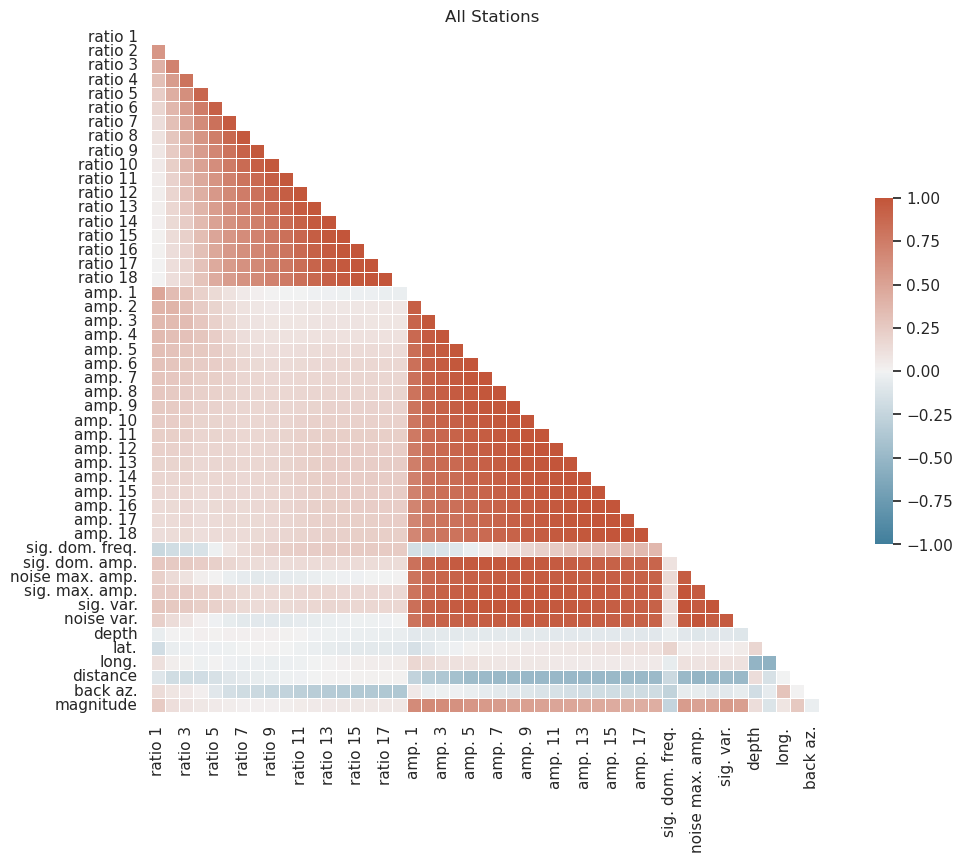

In [10]:
plotting.plot_pairwise_correlations(X_train, 
                                    y_train, 
                                    alt_names, 
                                    'All Stations')

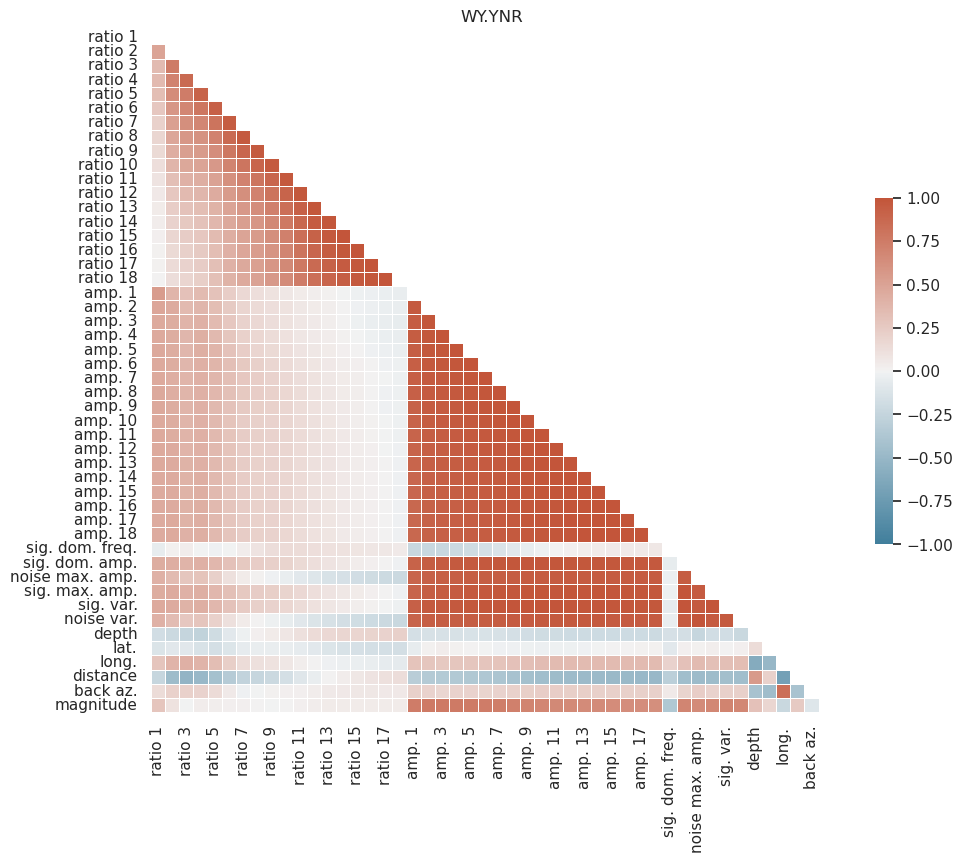

In [11]:
plotting.plot_pairwise_correlations(station_feature_dict['YNR']['X_train'], 
                                    station_meta_dict['YNR']['y_train'], 
                                    alt_names, 
                                    'WY.YNR')

## Look at the F-statistic of each feature to get a sense of which are the most important 

In [12]:
f_reg_scores, f_reg_station_order = ifs.compute_multiple_station_feature_scores(len(feature_names),
                                                                            station_feature_dict,
                                                                            station_meta_dict,
                                                                            ifs.f_reg_feature_selection)

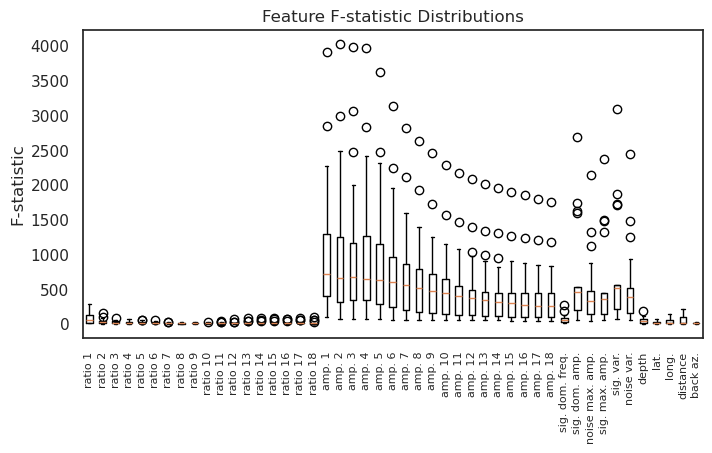

In [13]:
plotting.plot_intrinsic_score_box_whisker(f_reg_scores.T, 
                        'Feature F-statistic Distributions',
                        alt_names, 
                        'F-statistic')

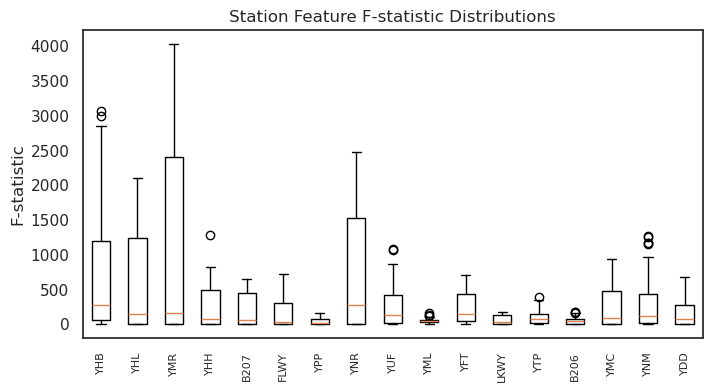

In [14]:
plotting.plot_intrinsic_score_box_whisker(f_reg_scores, 
                        'Station Feature F-statistic Distributions',
                        f_reg_station_order, 
                        'F-statistic')

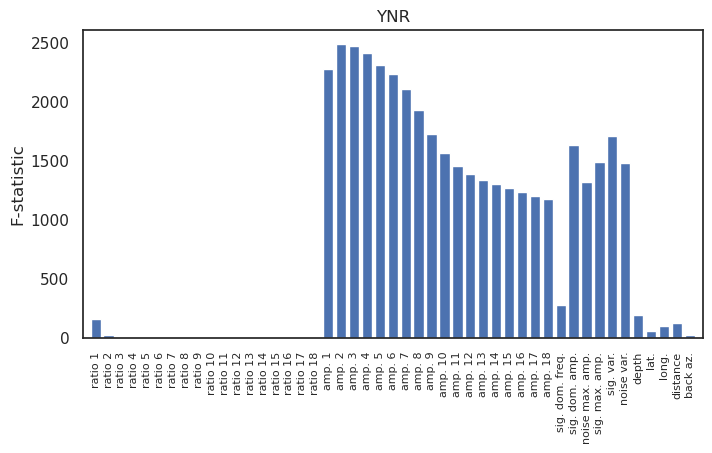

In [15]:
plotting.plot_station_intrinsic_score_bar_chart(f_reg_scores, 
                             f_reg_station_order,
                             'YNR',
                             alt_names,
                             'F-statistic')

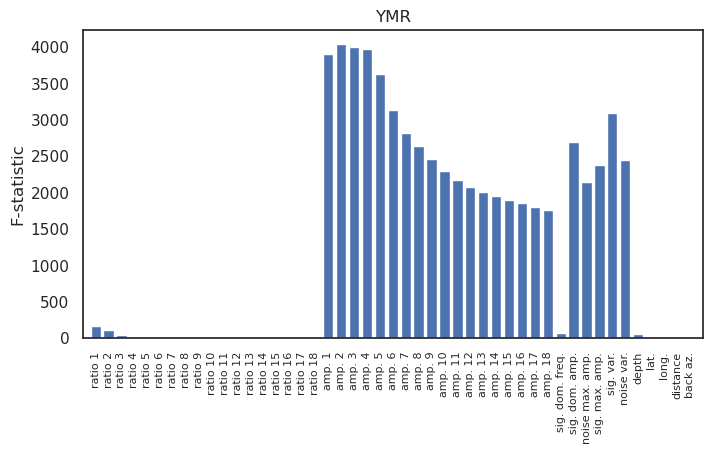

In [16]:
plotting.plot_station_intrinsic_score_bar_chart(f_reg_scores, 
                             f_reg_station_order,
                             'YMR',
                             alt_names,
                             'F-statistic')

In [17]:
f_reg_stat_feat_rankings = ifs.feature_rankings_for_individual_stations(f_reg_scores)
f_reg_feat_rankings = ifs.rank_features_across_stations(f_reg_scores, f_reg_stat_feat_rankings)

In [18]:
assert np.array_equal(feature_names[np.argsort(-1*f_reg_scores[:, np.where(f_reg_station_order == 'YNR')[0][0]])],
                      feature_names[f_reg_stat_feat_rankings[np.where(f_reg_station_order == 'YNR')[0][0], :]]),\
                      'Feature ranking function did not work correctly'

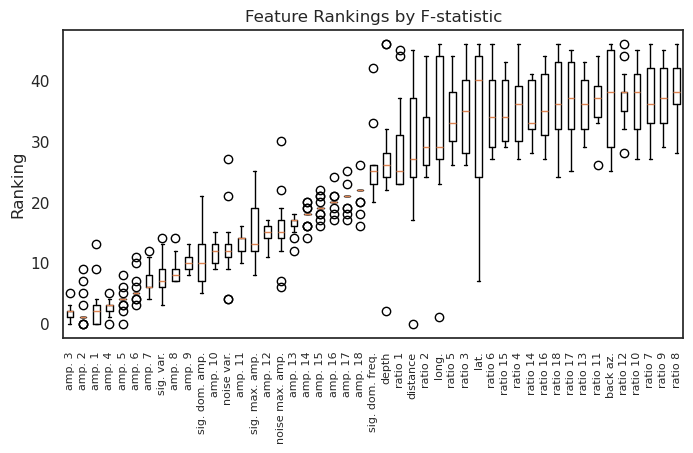

In [19]:
plotting.plot_intrinsic_score_box_whisker(f_reg_feat_rankings.T, 
                 'Feature Rankings by F-statistic',
                 alt_names, 
                 'Ranking',
                 sort_col_inds=np.argsort(np.sum(f_reg_feat_rankings, axis=1)))

In [20]:
f_reg_summary_rankings = feature_names[np.argsort(np.sum(f_reg_feat_rankings, axis=1))]

In [21]:
assert np.array_equal(feature_names[np.argsort(np.sum(f_reg_feat_rankings, axis=1))],
               feature_names[np.argsort(np.average(f_reg_feat_rankings, axis=1))]),\
               'Average and Sum or feature ranking do not produce the same order of features'

## Look at the mutual info of each feature to get a sense of which are the most important 

In [22]:
discrete_feature_bool = ifs.make_discrete_feature_bool(station_feature_dict['YNR']['X_train'],
                                                        feature_names,
                                                        discrete_perc_thresh=10)

amp_ratio_1 100.00
amp_ratio_2 100.00
amp_ratio_3 100.00
amp_ratio_4 100.00
amp_ratio_5 100.00
amp_ratio_6 100.00
amp_ratio_7 100.00
amp_ratio_8 100.00
amp_ratio_9 100.00
amp_ratio_10 100.00
amp_ratio_11 100.00
amp_ratio_12 100.00
amp_ratio_13 100.00
amp_ratio_14 100.00
amp_ratio_15 100.00
amp_ratio_16 100.00
amp_ratio_17 100.00
amp_ratio_18 100.00
amp_1 100.00
amp_2 100.00
amp_3 100.00
amp_4 100.00
amp_5 100.00
amp_6 100.00
amp_7 100.00
amp_8 100.00
amp_9 100.00
amp_10 100.00
amp_11 100.00
amp_12 100.00
amp_13 100.00
amp_14 100.00
amp_15 100.00
amp_16 100.00
amp_17 100.00
amp_18 100.00
signal_dominant_frequency 5.27
signal_dominant_amplitude 100.00
noise_max_amplitude 100.00
signal_max_amplitude 100.00
signal_variance 100.00
noise_variance 100.00
source_depth_km 44.28
source_latitude 45.68
source_longitude 65.19
source_receiver_distance_logkm 99.72
source_receiver_back_azimuth_sine 99.72


In [23]:
feature_names[np.where(discrete_feature_bool)[0]]

array(['signal_dominant_frequency'], dtype='<U33')

In [24]:
# Using the discrete mask didn't change the results. 'Auto' setting may have already set it as discrete?
mutual_reg_scores, mutual_reg_station_order = ifs.compute_multiple_station_feature_scores(len(feature_names),
                                                                            station_feature_dict,
                                                                            station_meta_dict,
                                                                            ifs.mutual_reg_feature_selection_discrete,
                                                                            discrete_bool=discrete_feature_bool)
                                                                            #mutual_reg_feature_selection)

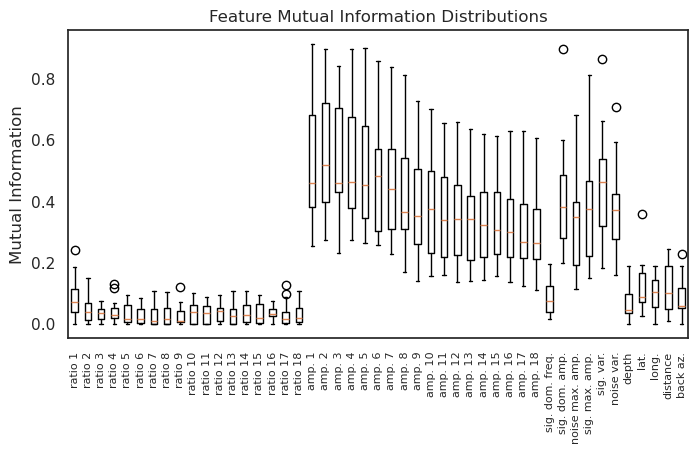

In [25]:
plotting.plot_intrinsic_score_box_whisker(mutual_reg_scores.T, 
                 'Feature Mutual Information Distributions',
                 alt_names, 
                 'Mutual Information')

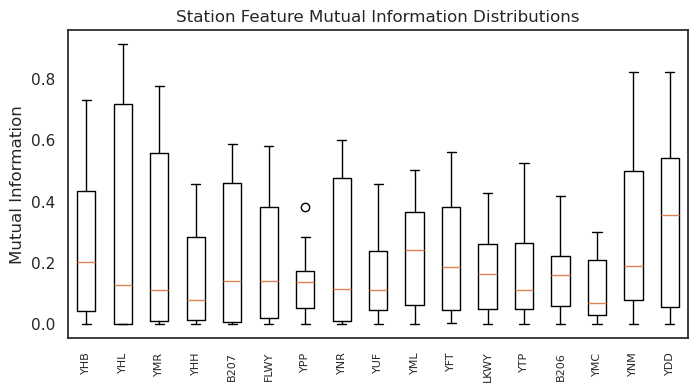

In [26]:
plotting.plot_intrinsic_score_box_whisker(mutual_reg_scores, 
                 'Station Feature Mutual Information Distributions',
                 mutual_reg_station_order, 
                 'Mutual Information')

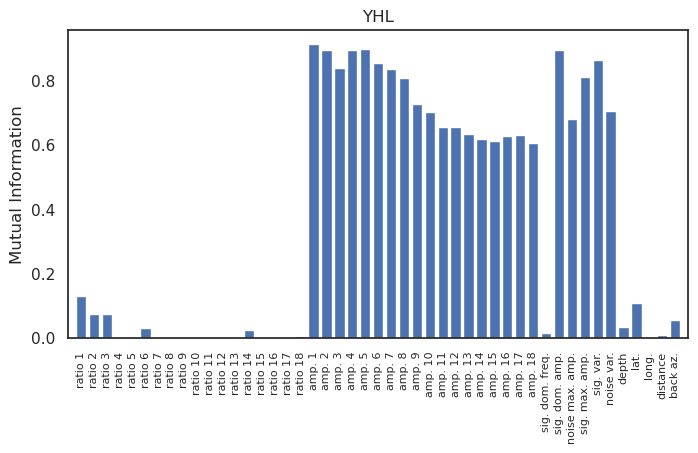

In [27]:
plotting.plot_station_intrinsic_score_bar_chart(mutual_reg_scores, 
                             mutual_reg_station_order,
                             'YHL',
                             alt_names,
                             'Mutual Information')

In [28]:
mutual_reg_stat_feat_rankings = ifs.feature_rankings_for_individual_stations(mutual_reg_scores)
mutual_reg_feat_rankings = ifs.rank_features_across_stations(mutual_reg_scores, mutual_reg_stat_feat_rankings)

In [29]:
assert np.array_equal(feature_names[np.argsort(-1*mutual_reg_scores[:, np.where(mutual_reg_station_order == 'YNR')[0][0]])],
                      feature_names[mutual_reg_stat_feat_rankings[np.where(mutual_reg_station_order == 'YNR')[0][0], :]]),\
                      'Feature ranking function did not work correctly'

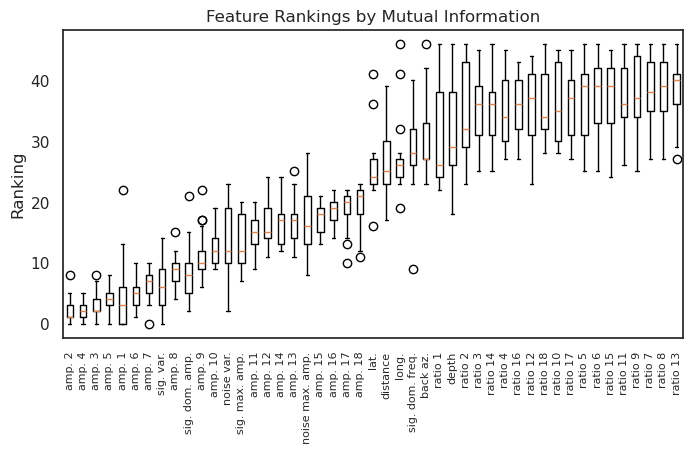

In [30]:
plotting.plot_intrinsic_score_box_whisker(mutual_reg_feat_rankings.T, 
                 'Feature Rankings by Mutual Information',
                 alt_names, 
                 'Ranking',
                 sort_col_inds=np.argsort(np.sum(mutual_reg_feat_rankings, axis=1)))

In [31]:
mutual_reg_summary_rankings = feature_names[np.argsort(np.sum(mutual_reg_feat_rankings, axis=1))]

# Who has Lat/Lon with a lot of mutual info?

In [32]:
np.where(np.isin(feature_names, ['source_latitude', 'source_longitude']))

(array([43, 44]),)

In [33]:
mutual_reg_station_order[np.unique(np.where(mutual_reg_feat_rankings[43:45, :] < 5)[1])]

array([], dtype='<U4')

# SR-dist and back-azimuth?

In [34]:
np.where(np.isin(feature_names, ['source_receiver_distance_logkm', 'source_receiver_back_azimuth_sine']))

(array([45, 46]),)

In [35]:
np.unique(np.where(mutual_reg_feat_rankings[45:46, :] < 5)[1])

array([], dtype=int64)

In [36]:
mutual_reg_station_order[np.unique(np.where(mutual_reg_feat_rankings[45:47, :] < 5)[1])]

array([], dtype='<U4')

# Look at important features from both F-stat and Mutual Information next to each other

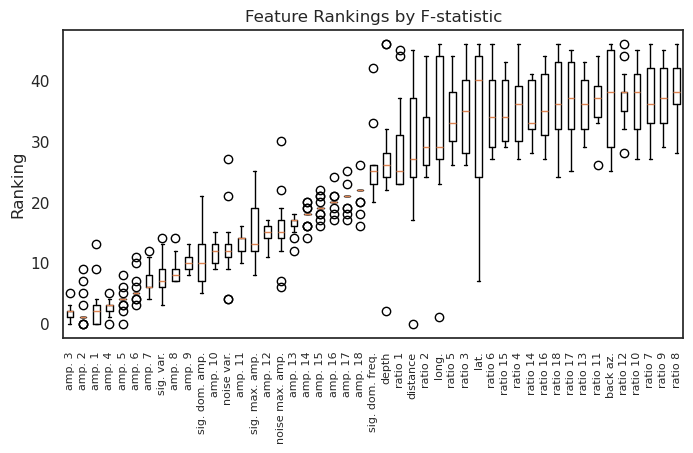

In [37]:
plotting.plot_intrinsic_score_box_whisker(f_reg_feat_rankings.T, 
                 'Feature Rankings by F-statistic',
                 alt_names, 
                 'Ranking',
                 sort_col_inds=np.argsort(np.sum(f_reg_feat_rankings, axis=1)))

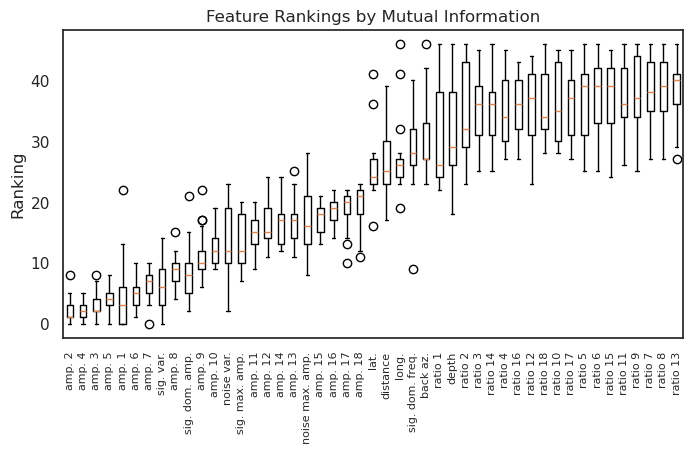

In [38]:
plotting.plot_intrinsic_score_box_whisker(mutual_reg_feat_rankings.T, 
                 'Feature Rankings by Mutual Information',
                 alt_names, 
                 'Ranking',
                 sort_col_inds=np.argsort(np.sum(mutual_reg_feat_rankings, axis=1)))

In [39]:
f_reg_summary_rankings

array(['amp_3', 'amp_2', 'amp_1', 'amp_4', 'amp_5', 'amp_6', 'amp_7',
       'signal_variance', 'amp_8', 'amp_9', 'signal_dominant_amplitude',
       'amp_10', 'noise_variance', 'amp_11', 'signal_max_amplitude',
       'amp_12', 'noise_max_amplitude', 'amp_13', 'amp_14', 'amp_15',
       'amp_16', 'amp_17', 'amp_18', 'signal_dominant_frequency',
       'source_depth_km', 'amp_ratio_1', 'source_receiver_distance_logkm',
       'amp_ratio_2', 'source_longitude', 'amp_ratio_5', 'amp_ratio_3',
       'source_latitude', 'amp_ratio_6', 'amp_ratio_15', 'amp_ratio_4',
       'amp_ratio_14', 'amp_ratio_16', 'amp_ratio_18', 'amp_ratio_17',
       'amp_ratio_13', 'amp_ratio_11',
       'source_receiver_back_azimuth_sine', 'amp_ratio_12',
       'amp_ratio_10', 'amp_ratio_7', 'amp_ratio_9', 'amp_ratio_8'],
      dtype='<U33')

In [40]:
mutual_reg_summary_rankings

array(['amp_2', 'amp_4', 'amp_3', 'amp_5', 'amp_1', 'amp_6', 'amp_7',
       'signal_variance', 'amp_8', 'signal_dominant_amplitude', 'amp_9',
       'amp_10', 'noise_variance', 'signal_max_amplitude', 'amp_11',
       'amp_12', 'amp_14', 'amp_13', 'noise_max_amplitude', 'amp_15',
       'amp_16', 'amp_17', 'amp_18', 'source_latitude',
       'source_receiver_distance_logkm', 'source_longitude',
       'signal_dominant_frequency', 'source_receiver_back_azimuth_sine',
       'amp_ratio_1', 'source_depth_km', 'amp_ratio_2', 'amp_ratio_3',
       'amp_ratio_14', 'amp_ratio_4', 'amp_ratio_16', 'amp_ratio_12',
       'amp_ratio_18', 'amp_ratio_10', 'amp_ratio_17', 'amp_ratio_5',
       'amp_ratio_6', 'amp_ratio_15', 'amp_ratio_11', 'amp_ratio_9',
       'amp_ratio_7', 'amp_ratio_8', 'amp_ratio_13'], dtype='<U33')

Since amplitudes and amplitude ratios are highly correlated - focus on those with the most information w.r.t. magnitude

Amps: 1-5 (6 & 7 also up there)   
Ratio: 1-4

Top 7 ratios   
Mutual: 1, 2, 3, 14, 4, 16, 12  
F-Stat: 1, 2, 5, 3, 6, 15, 4,


The issue with this though is that it is possible some of the other amps or ratios that are less relevant for magnitude by themselves, but they could be helpful when combined with other features.

In [41]:
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km', 'source_latitude',
       'source_longitude', 'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_sine'], dtype='<U33')

In [42]:
feature_subset = ['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
'amp_1', 'amp_2', 'amp_3', 'amp_4','amp_5', 'signal_dominant_frequency',
'signal_dominant_amplitude',
'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
'noise_variance', 'source_depth_km', 'source_latitude',
'source_longitude', 'source_receiver_distance_logkm',
'source_receiver_back_azimuth_sine']

In [43]:
feature_subset_cols = np.where(np.isin(feature_names, feature_subset))[0]
feature_subset_cols

array([ 0,  1,  2,  3, 18, 19, 20, 21, 22, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46])

In [44]:
np.array(alt_names)[feature_subset_cols]

array(['ratio 1', 'ratio 2', 'ratio 3', 'ratio 4', 'amp. 1', 'amp. 2',
       'amp. 3', 'amp. 4', 'amp. 5', 'sig. dom. freq.', 'sig. dom. amp.',
       'noise max. amp.', 'sig. max. amp.', 'sig. var.', 'noise var.',
       'depth', 'lat.', 'long.', 'distance', 'back az.'], dtype='<U15')

In [45]:
station_feature_dict['YNR']['X_train'][:, feature_subset_cols].shape

(1784, 20)

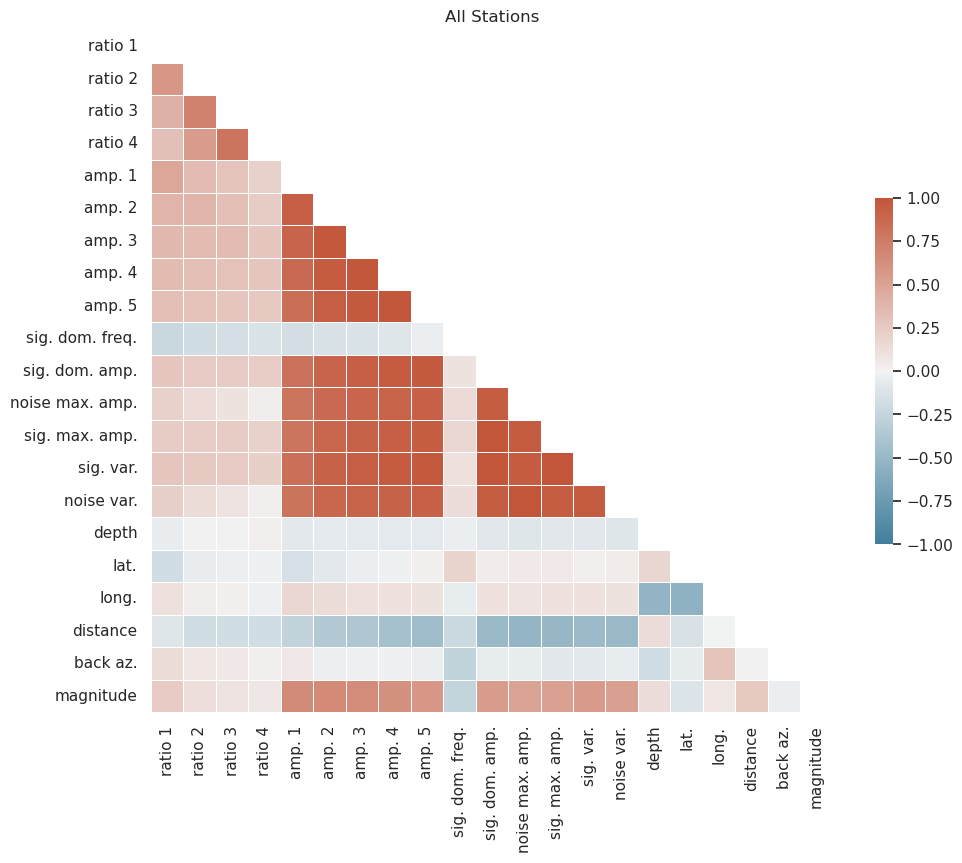

In [46]:
plotting.plot_pairwise_correlations(X_train[:, feature_subset_cols], 
                           y_train, 
                           np.array(alt_names)[feature_subset_cols], 
                           'All Stations',
                           xticklabels=1)